# Проект: классификация

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [225]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0 $,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,"830,00 $",yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,"545,00 $",yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,"1,00 $",yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,NaN,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [226]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
print(df.info(), '\n')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None 

age           0
job           0
marital       0
education     0
default       0
balance     

### Задание 2

In [227]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [228]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
import re

def balance_extraction(some_str):
    if not some_str:
        return None
    else:
        res = re.sub(r'[$\s]','', str(some_str))
        res = re.sub(r'[,]','.', res)
        return float(res)
    
df['balance'] = df['balance'].apply(balance_extraction)
df['balance'].mean().round(3)


1529.129

### Задание 4

In [229]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df= df.fillna( {'balance':df['balance'].median()})

df['balance'].mean().round(3)

1526.936

### Задание 5

In [230]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

df['job'] = df['job'].replace({'unknown' : df['job'].mode()[0]})
df['education'] = df['education'].replace({'unknown' : df['education'].mode()[0]})

df[(df['job'] == df['job'].value_counts().index[0]) & (df['education'] == df['education'].value_counts().index[0])]['balance'].mean().round(3)


1598.883

### Задание 6

In [231]:
# удалите все выбросы для признака balance
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - left*iqr
    upper_bound = quartile_3 + right*iqr
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned, (lower_bound, upper_bound)

outliers, cleaned, bounds = outliers_iqr_mod(df, 'balance') 

print('Верхняя и нижняя границы поиска выбросов по методу Тьюки', bounds)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')



Верхняя и нижняя границы поиска выбросов по методу Тьюки (-2241.0, 4063.0)
Число выбросов по методу Тьюки: 1057


### Задание 7

In [232]:
#Сколько объектов осталось после удаления всех выбросов?

to_drop = df[(df['balance'] < bounds[0]) | (df['balance'] > bounds[1])].index
df.drop(index=to_drop, inplace = True)
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

Наличие депозита у клиентов
 no     5424
yes    4681
Name: deposit, dtype: int64


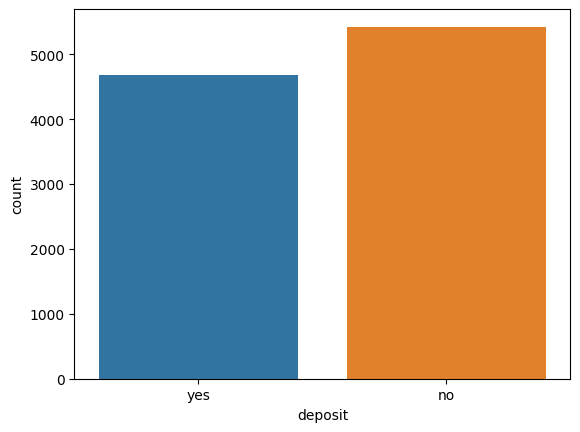

In [233]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit');
print('Наличие депозита у клиентов\n', df['deposit'].value_counts())

### Задания 2 и 3

Максимальный возраст клиента банка 95
Минимальная продолжительность разговора с клиентом банка 2 

            age   balance       day  duration  campaign     pdays  previous
count  10105.00  10105.00  10105.00  10105.00  10105.00  10105.00  10105.00
mean      40.90    807.65     15.59    368.74      2.52     51.32      0.82
std       11.73    994.15      8.44    346.65      2.71    109.64      2.24
min       18.00  -2049.00      1.00      2.00      1.00     -1.00      0.00
25%       32.00     95.00      8.00    137.00      1.00     -1.00      0.00
50%       38.00    445.00     15.00    252.00      2.00     -1.00      0.00
75%       48.00   1227.00     22.00    490.00      3.00      2.00      1.00
max       95.00   4063.00     31.00   3881.00     43.00    854.00     58.00
Число выбросов в  age  с меньшей стороны по методу z-отклонения: 0
Число выбросов в  age с большей стороны по методу z-отклонения: 174
Число выбросов в  balance  с меньшей стороны по методу z-отклонения: 5
Число выбро

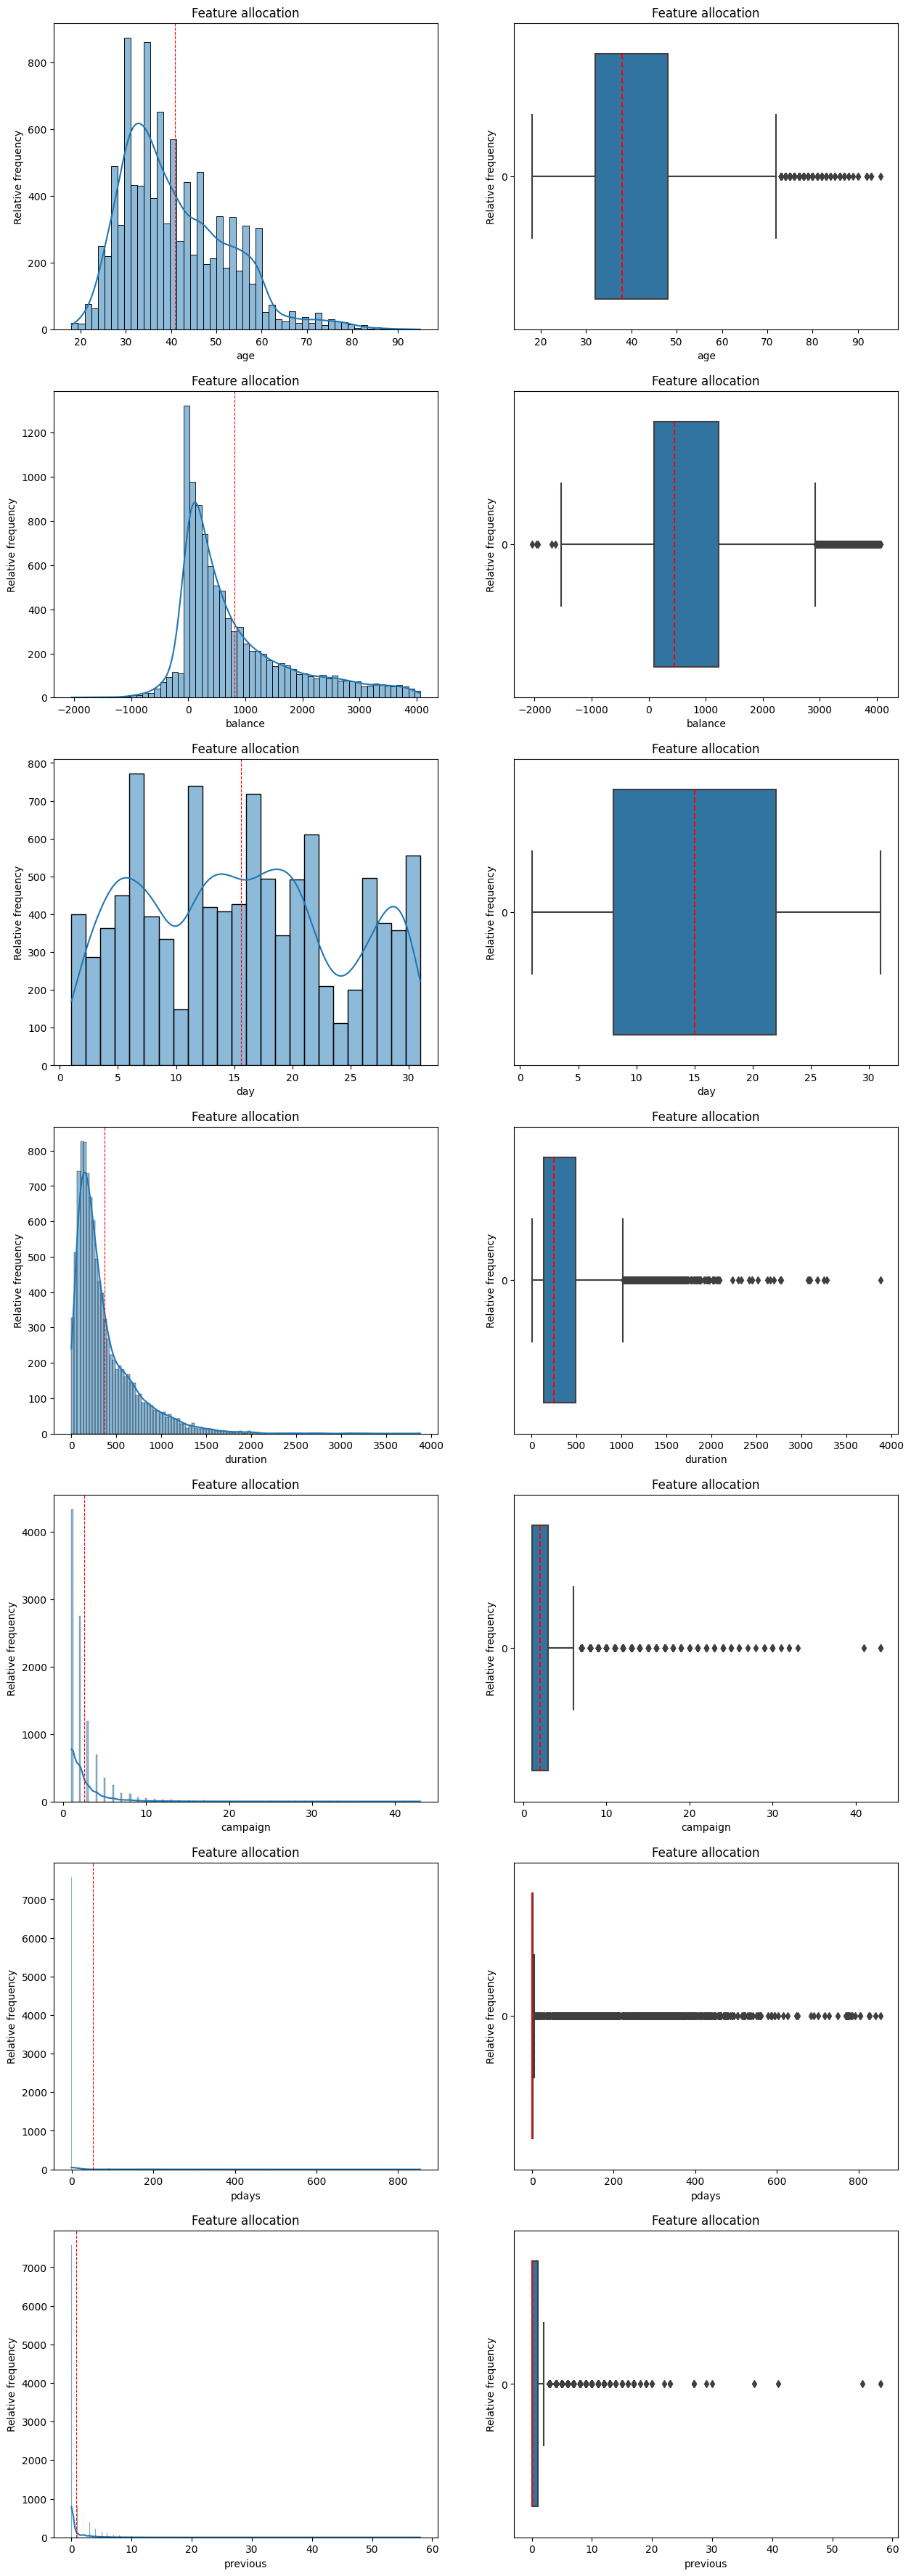

In [234]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print('Максимальный возраст клиента банка',df['age'].max())
print('Минимальная продолжительность разговора с клиентом банка', df['duration'].min(),'\n')
print(df.describe().round(2))

types = df.dtypes
numeric = types[(types != 'object')].index.to_list()

def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - left*iqr
    upper_bound = quartile_3 + right*iqr
    left_outlier, right_outlier = data[x < lower_bound], data[x > upper_bound]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return left_outlier, right_outlier, cleaned

for n in numeric:
    left_outlier, right_outlier, cleaned = outliers_iqr_mod(df, n)
    print('Число выбросов в ',n,' с меньшей стороны по методу z-отклонения:', left_outlier.shape[0])
    print('Число выбросов в ',n,'с большей стороны по методу z-отклонения:', right_outlier.shape[0])

"""print('\n')

def outliers_z_score_mod(data, feature, log_scale=False, left = 3, right = 3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    left_outlier, right_outlier = data[x < lower_bound], data[x > upper_bound]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return left_outlier, right_outlier, cleaned

for n in numeric:
    left_outlier, right_outlier, cleaned = outliers_z_score_mod(df, n)
    print('Число выбросов в ',n,' с меньшей стороны по методу z-отклонения:', left_outlier.shape[0])
    print('Число выбросов в ',n,'с большей стороны по методу z-отклонения:', right_outlier.shape[0])"""
    
    
n = len(numeric) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize = (15, 45)) # фигура + n х 2 координатных плоскостей
for i, f in enumerate(numeric): #i- индекс, feature - название признака в таблице
    
    sns.histplot(df[f], kde=True, ax=axes[i][0])
    axes[i][0].set(xlabel=f, ylabel='Relative frequency')
    axes[i][0].set_title('Feature allocation')
    axes[i][0].axvline(df[f].mean(), color='red', linestyle='--', linewidth=0.8)

    sns.boxplot(df[f], ax=axes[i][1], orient='h', medianprops={"color": "r", "linestyle": '--'})
    axes[i][1].set(xlabel=f, ylabel='Relative frequency')
    axes[i][1].set_title('Feature allocation')
plt.show()

### Задания 4 и 5

In [235]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [236]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [237]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [238]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [239]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [240]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [241]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [242]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [243]:
# преобразуйте уровни образования

### Задания 2 и 3

In [244]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [245]:
# создайте дамми-переменные

### Задания 5 и 6

In [246]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [247]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [248]:
# рассчитайте необходимые показатели

### Задание 9

In [249]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [250]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [251]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [252]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [253]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [254]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [255]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [256]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [257]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [258]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna